In [206]:
%reload_ext autoreload
%autoreload 2

In [207]:
from pathlib import Path
from nlp_dauphine.preprocess_data import (
        load_data, 
        text_cleaning, 
        link_texts_series, 
        suppr_footnotes, 
        categorical_other,
        find_language,
        )
from nlp_dauphine.embeddings import vocabulary
from nlp_dauphine.utils import set_working_dir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from category_encoders import WOEEncoder
from deep_translator import GoogleTranslator
from langdetect import detect
import csv
from sklearn.decomposition import TruncatedSVD
from nlp_dauphine.embeddings import print_neighbors
from nlp_dauphine.utils import cosine, euclidean
from nlp_dauphine.embeddings import sentence_representations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [155]:
set_working_dir()

Current working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine


# Load Data

In [167]:
path = Path("data")
files_path = {
    "ecb": Path(path,"ecb_data.csv"),
    "fed": Path(path,"fed_data.csv"),
    "train_series": Path(path,"train_series.csv"),
}

In [168]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 3) (739, 3) (8946, 14)


# Text Cleaning

## Link Texts to Series

Create some indices

In [169]:
df_ecb.reset_index(inplace=True, names="id_ecb")
df_fed.reset_index(inplace=True, names="id_fed")
df_train_series.reset_index(inplace=True, names="id_series")

Create a list rather than a string with a comma separator

In [170]:
df_train_series["id_ecb"] = [x.split(",") for x in df_train_series['index ecb']]
df_train_series["id_fed"] = [x.split(",") for x in df_train_series['index fed']]
del df_train_series['index ecb']
del df_train_series['index fed']

## Remove Footnotes

In [171]:
df_ecb["text_process"] = df_ecb.text.apply(lambda x: suppr_footnotes(x))
df_fed["text_process"] = df_fed.text.apply(lambda x: suppr_footnotes(x))

## Deal with Null Values

In [172]:
# REPLACE NULL TEXTS BY TITLE
index_no_texts_ecb = df_ecb[df_ecb["text_process"].isnull()].index.values
df_ecb.loc[index_no_texts_ecb, "text_process"] = df_ecb.loc[index_no_texts_ecb, "title"].values

In [173]:
index_no_texts_fed = [i for i in range(len(df_fed.text_process)) if (df_fed.text_process[i] == '         ') or (df_fed.text_process[i] == '        ') or (df_fed.text_process[i] == ' ') or ()]
df_fed.loc[index_no_texts_fed, "text_process"] = df_fed.loc[index_no_texts_fed, "title"].values

## Translate Texts

In [174]:
df_ecb["lang"] = find_language(df_ecb.text_process) 
df_fed["lang"] = find_language(df_fed.text_process)
print(df_ecb.lang.value_counts())
print(df_fed.lang.value_counts())

en    1678
de      63
es      16
fr      12
it       3
Name: lang, dtype: int64
en    738
de      1
Name: lang, dtype: int64


The texts are cut to 5000 char

In [175]:
df_ecb.text_process = df_ecb.apply(
    lambda row: GoogleTranslator(source=row.lang, target="en").translate(
        text=row.text_process[:4999]
    )
    if row.lang != "en"
    else row.text_process,
    axis=1,
)


In [72]:
df_ecb.loc[df_ecb.lang != "en"].head()

,id_ecb,title,speaker,text,text_process,lang
31,31,Die Finanzmarktunion als Element einer stabile...,Jörg Asmussen,Die Finanzmarktunion als Element einer stabi...,The Financial Markets Union as an Element of a...,de
40,40,"Die EZB, das Geld und die Wirtschaft: Von A wi...",Sabine Lautenschläger,NaN,"The ECB, money and the economy: from A for rec...",de
48,48,SEPA in der Praxis - Sicht der Europäischen Ze...,Gertrude Tumpel-Gugerell,SEPA in der Praxis – Sicht der Europäischen ...,SEPA in Practice – Perspective of the European...,de
66,66,Auf dem Weg zum Euro - allegro ma non troppo,Jörg Asmussen,Auf dem Weg zum Euro – allegro ma non troppo...,On the way to the euro – allegro ma non troppo...,de
138,138,Discours délivré à l'occasion de la réception ...,Jean-Claude Trichet,Discours délivré à l'occasion de la réceptio...,Speech delivered on the occasion of the recept...,fr


## Remove special characters, stop words, Lemmatization...

In [176]:
# Clean Data
negation_words = ["no", "not", "never", "none", "nobody"]
df_fed.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_fed.text_process]
df_ecb.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_ecb.text_process]

Length of the texts

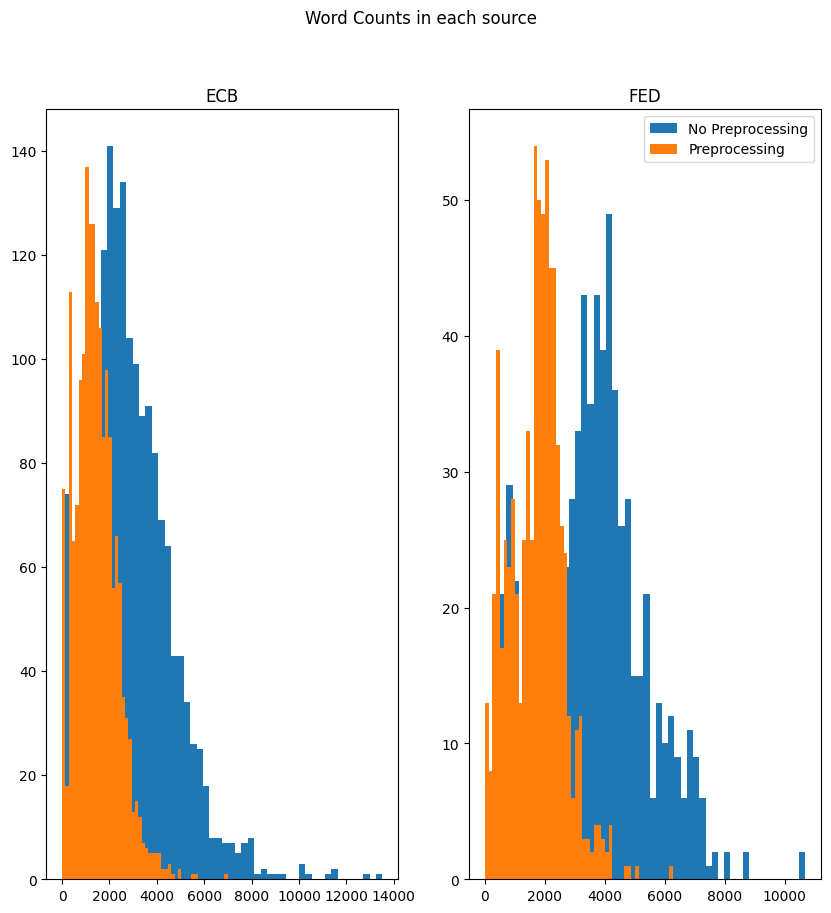

In [74]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text]
lenght_texts_ecb_process = [len(str(x).split(" ")) for x in df_ecb.text_process]
lenght_texts_fed_process = [len(str(x).split(" ")) for x in df_fed.text_process]
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].hist(lenght_texts_ecb, bins=50,label="No Preprocessing")
ax[0].hist(lenght_texts_ecb_process, bins=50,label="Preprocessing")
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50,label="No Preprocessing")
ax[1].hist(lenght_texts_fed_process, bins=50,label="Preprocessing")
ax[1].set_title("FED")
fig.suptitle("Word Counts in each source")
plt.legend(loc="upper right")
plt.show()

# Text Truncature

No more than `threshold` words

Still some doubts about it

In [177]:
threshold = 4000
df_ecb.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_ecb.text_process]
df_fed.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_fed.text_process]

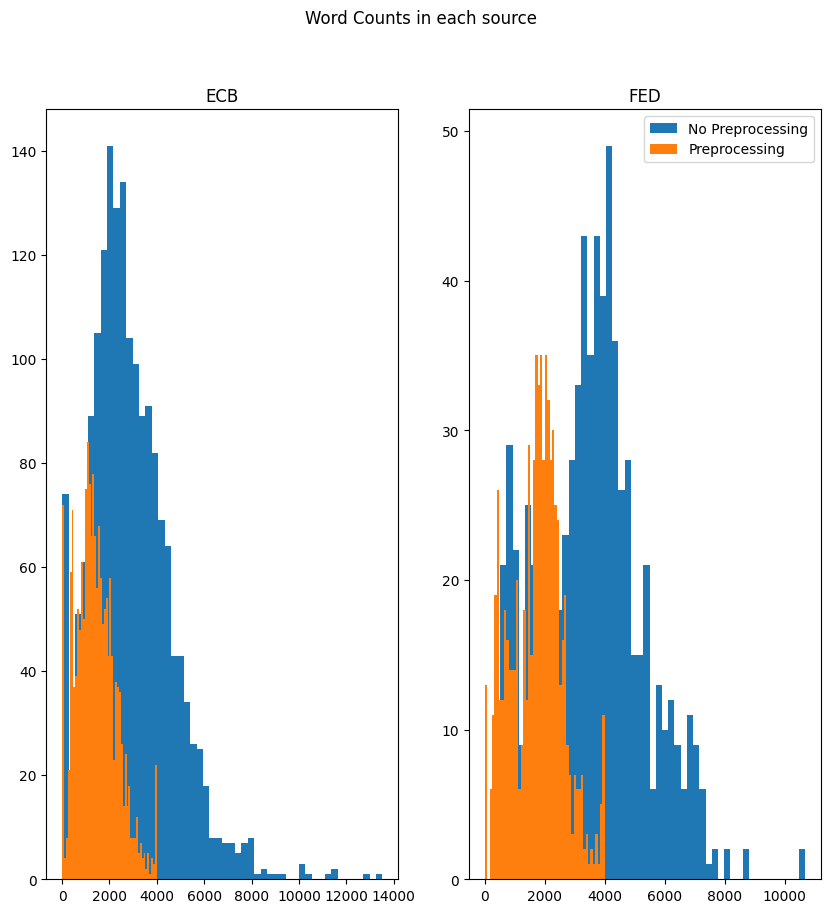

In [92]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text]
lenght_texts_ecb_process = [len(str(x).split(" ")) for x in df_ecb.text_process]
lenght_texts_fed_process = [len(str(x).split(" ")) for x in df_fed.text_process]
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].hist(lenght_texts_ecb, bins=50,label="No Preprocessing")
ax[0].hist(lenght_texts_ecb_process, bins=50,label="Preprocessing")
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50,label="No Preprocessing")
ax[1].hist(lenght_texts_fed_process, bins=50,label="Preprocessing")
ax[1].set_title("FED")
fig.suptitle("Word Counts in each source")
plt.legend(loc="upper right")
plt.show()

# Categorical Variable: Speakers

In [93]:
df_fed.speaker.value_counts()

Chairman Ben S. Bernanke                        145
Governor Lael Brainard                           68
Governor Daniel K. Tarullo                       54
Governor Jerome H. Powell                        50
Vice Chairman Stanley Fischer                    45
Governor Elizabeth A. Duke                       44
Chair Janet L. Yellen                            44
Vice Chairman Donald L. Kohn                     41
Vice Chair for Supervision Randal K. Quarles     39
Governor Randall S. Kroszner                     36
Chairman Jerome H. Powell                        32
Governor Frederic S. Mishkin                     26
Vice Chairman Richard H. Clarida                 26
Vice Chair Janet L. Yellen                       22
Governor Sarah Bloom Raskin                      17
Governor Kevin Warsh                             16
Governor Jeremy C. Stein                         16
Governor Michelle W. Bowman                      13
Governor Susan S. Bies                            3
Name: speake

In [178]:
df_ecb.speaker = categorical_other(df_ecb.speaker)
df_fed.speaker = categorical_other(df_fed.speaker, threshold=0.025)

# Text Concatenation

In [13]:
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]"
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261]


In [179]:
df_series_ecb_process = link_texts_series(df_train_series, df_ecb, "id_series", "id_ecb")
df_series_fed_process = link_texts_series(df_train_series, df_fed, "id_series", "id_fed")

In [180]:
df_train_series = df_train_series.merge(df_series_ecb_process,on='id_series',how='left')
df_train_series = df_train_series.merge(df_series_fed_process,on='id_series',how='left')
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96],welcome address welcome remark philip r lane m...,"[Philip R. Lane, Luis de Guindos]",delighted helsinki important conference moneta...,[Vice Chairman Richard H. Clarida]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568],monetary policy structural reform euro area sp...,[Mario Draghi],watch live would like thank federal reserve ba...,[Vice Chairman Stanley Fischer]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]",challenge opportunity reboot european financia...,"[Benoît Cœuré, Benoît Cœuré]",grateful national association business economi...,"[Vice Chairman Stanley Fischer, Governor Lael ..."
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118],create stability uncertain world speech peter ...,"[Peter Praet, Peter Praet]",thank invitation speak today begin take stock ...,[Governor Jerome H. Powell]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261],money private currency reflection libra speech...,[Yves Mersch],year symposium topic challenge monetary policy...,[Chairman Jerome H. Powell]


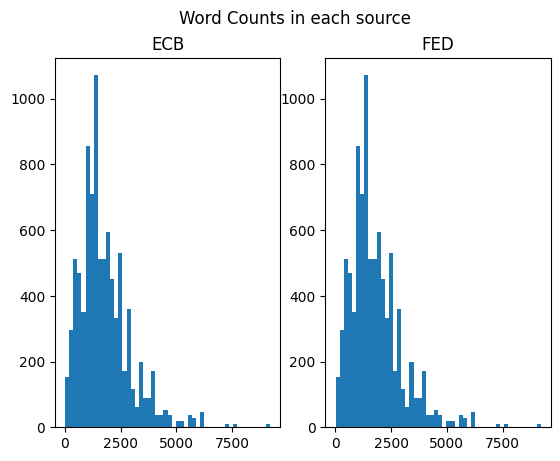

In [99]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_train_series.text_concat_ecb]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_train_series.text_concat_ecb]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
fig.suptitle("Word Counts in each source")
plt.show()

# Removal Zero value Time series

Probably due to a score approximation 

Some times all indices are null

In [100]:
df_train_series.loc[df_train_series['Index + 1']==0.0]['Index Name'].value_counts()

SRVIX Index         428
CVIX Index           70
MOVE Index           50
VIX Index            41
V2X Index            36
SPX Index            36
SX5E Index           25
EURUSDV1M Curncy     13
EURUSD Curncy         7
Name: Index Name, dtype: int64

In [181]:
sup = df_train_series.loc[df_train_series['Index + 1']==0.0].index
df_train_series.drop(sup,inplace=True)

**Business rules**

If the entire series is full of zeros -> Output = 0

In [182]:
df_train_series.to_csv("./data/train_series_clean_no_0.csv")

# Loughran McDonald Test (not really useful for now)

No need for stemming/lemming

Upper case Necessary

In [110]:
df_ecb_mc, df_fed_mc, df_train_series_mc = load_data(files_path)
print(df_ecb_mc.shape, df_fed_mc.shape, df_train_series_mc.shape)

df_ecb_mc.reset_index(inplace=True, names="id_ecb")
df_fed_mc.reset_index(inplace=True, names="id_fed")
df_train_series_mc.reset_index(inplace=True, names="id_series")

df_train_series_mc["id_ecb"] = [x.split(",") for x in df_train_series_mc['index ecb']]
df_train_series_mc["id_fed"] = [x.split(",") for x in df_train_series_mc['index fed']]
del df_train_series_mc['index ecb']
del df_train_series_mc['index fed']

df_ecb_mc["text_process"] = df_ecb_mc.text.apply(lambda x: suppr_footnotes(x))
df_fed_mc["text_process"] = df_fed_mc.text.apply(lambda x: suppr_footnotes(x))

# REPLACE NULL TEXTS BY TITLE
index_no_texts_ecb = df_ecb_mc[df_ecb_mc["text_process"].isnull()].index.values
df_ecb_mc.loc[index_no_texts_ecb, "text_process"] = df_ecb_mc.loc[index_no_texts_ecb, "title"].values

index_no_texts_fed = [i for i in range(len(df_fed_mc.text_process)) if (df_fed_mc.text_process[i] == '         ') or (df_fed_mc.text_process[i] == '        ') or (df_fed_mc.text_process[i] == ' ') or ()]
df_fed_mc.loc[index_no_texts_fed, "text_process"] = df_fed_mc.loc[index_no_texts_fed, "title"].values

df_ecb_mc["lang"] = find_language(df_ecb_mc.text_process) 
df_fed_mc["lang"] = find_language(df_ecb_mc.text_process)
print(df_ecb_mc.lang.value_counts())
print(df_fed_mc.lang.value_counts())

df_ecb_mc.text_process = df_ecb_mc.apply(
    lambda row: GoogleTranslator(source=row.lang, target="en").translate(
        text=row.text_process[:4999]
    )
    if row.lang != "en"
    else row.text_process,
    axis=1,
)

# Clean Data
negation_words = ["no", "not", "never", "none", "nobody"]
df_fed_mc.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=False,
    ) for x in df_fed_mc.text_process]
df_ecb_mc.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=False,
    ) for x in df_ecb_mc.text_process]

threshold = 4000
df_ecb_mc.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_ecb_mc.text_process]
df_fed_mc.text_process = [" ".join(txt.split(" ")[:threshold]) for txt in df_fed_mc.text_process]

df_ecb_mc

(1772, 3) (739, 3) (8946, 14)
en    1678
de      63
es      16
fr      12
it       3
Name: lang, dtype: int64
en    697
de     29
es      8
fr      5
Name: lang, dtype: int64


,id_ecb,title,speaker,text,text_process,lang
0,0,Comments by Yves Mersch at Financial Services ...,Yves Mersch,Comments by Yves Mersch at Financial Service...,comments yves mersch financial services summit...,en
1,1,Securing sustained economic growth in the euro...,Vítor Constâncio,Securing sustained economic growth in the eu...,securing sustained economic growth euro area s...,en
2,2,The role of monetary policy in addressing the ...,Mario Draghi,The role of monetary policy in addressing th...,role monetary policy addressing crisis euro ar...,en
3,3,The pandemic emergency: the three challenges f...,Philip R. Lane,SPEECH The pandemic emergency: the three c...,speech pandemic emergency three challenges ecb...,en
4,4,Transmission channels of monetary policy in th...,Peter Praet,Transmission channels of monetary policy in ...,transmission channels monetary policy current ...,en
...,...,...,...,...,...,...
1767,1767,"Navigating uncertainty - governance, risk mana...",Sabine Lautenschläger,"Navigating uncertainty – governance, risk ma...",navigating uncertainty governance risk managem...,en
1768,1768,3-6-3: Banks and change,Sabine Lautenschläger,3-6-3: Banks and change Speech by Sabine L...,3 banks change speech sabine lautenschläger me...,en
1769,1769,Europe's pursuit of ‘a more perfect Union',Mario Draghi,Europe’s pursuit of ‘a more perfect Union’ ...,europe pursuit perfect union lecture mario dra...,en
1770,1770,Monetary policy in the euro area - a brief ass...,Yves Mersch,Monetary policy in the euro area - a brief a...,monetary policy euro area brief assessment spe...,en


In [115]:
df_ecb_mc.text_process = [txt.upper() for txt in df_ecb_mc.text_process]
df_fed_mc.text_process = [txt.upper() for txt in df_fed_mc.text_process]

In [102]:
master_dictionary_file= "data\Loughran_McDonald_Dictionary.csv"
master_dictionary = {}
with open(master_dictionary_file) as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=",")
    line_count = 0
    for row in csv_reader:
        master_dictionary[row["Word"]] = row
        line_count += 1
print(f"master dictionary has {len(master_dictionary)} words.")

master dictionary has 86531 words.


In [117]:
master_dictionary["EDUCATOR"]

{'Word': 'EDUCATOR',
 'Seq_num': '23795',
 'Word Count': '3418',
 'Word Proportion': '1.4966592569110276e-07',
 'Average Proportion': '1.3846473545104947e-07',
 'Std Dev': '7.033208155577571e-06',
 'Doc Count': '1639',
 'Negative': '0',
 'Positive': '0',
 'Uncertainty': '0',
 'Litigious': '0',
 'Strong_Modal': '0',
 'Weak_Modal': '0',
 'Constraining': '0',
 'Syllables': '4',
 'Source': '12of12inf'}

In [122]:
word2id_7500,id2word_7500 = vocabulary(df_ecb_mc.text_process,7500)

In [109]:
SENTIMENT_OUTPUT_FIELDS = {
    "Negative": 1,
    "Positive": 1,
    "Uncertainty": 1,
    "Litigious": 1,
    "Strong_Modal": 1,
    "Weak_Modal": 1,
    "Constraining": 1,
}

for txt in df_ecb_mc.text_process:
    txt_tokenize = txt.split(" ")
    total_tokens = 0
    for token in txt_tokenize:
        
        if (len(token) > 1
            and master_dictionary.get(token) is not None
            and token in word2id_7500.keys()):

            for key, item in SENTIMENT_OUTPUT_FIELDS.items():
                if (
                    master_dictionary[token][key] != "0"
                    and master_dictionary[token][key] != 0
                    and master_dictionary[token][key] != None
                ):
                    output_data[FIXED_OUTPUT_FIELDS.index(key)] += item

{'Word': 'THE',
 'Seq_num': '76950',
 'Word Count': '1586170835',
 'Word Proportion': '0.0694545717742845',
 'Average Proportion': '0.0698425525301629',
 'Std Dev': '0.011183918478162379',
 'Doc Count': '1140097',
 'Negative': '0',
 'Positive': '0',
 'Uncertainty': '0',
 'Litigious': '0',
 'Strong_Modal': '0',
 'Weak_Modal': '0',
 'Constraining': '0',
 'Syllables': '1',
 'Source': '12of12inf'}

# Train Test Split

In [150]:
df_train_series.columns

Index(['id_series', 'Index Name', 'Index - 9', 'Index - 8', 'Index - 7',
       'Index - 6', 'Index - 5', 'Index - 4', 'Index - 3', 'Index - 2',
       'Index - 1', 'Index - 0', 'id_ecb', 'id_fed', 'text_concat_ecb',
       'list_speakers_ecb', 'text_concat_fed', 'list_speakers_fed',
       'speaker_1', 'speaker_2', 'speaker_3', 'speaker_4'],
      dtype='object')

In [183]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=np.sign(df_train_series[["Index + 1"]])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(X_train.shape,y_train.shape)

(6592, 18) (6592, 1)


Binary Classification no class Imbalance

In [187]:
y_test.value_counts()

Index + 1
-1.0         859
 1.0         789
dtype: int64

# Categorical Encoding 

For the speakers WOEEncoder rather than One-hot encoding

In [188]:
col_speakers = ["speaker_"+str(i+1) for i in range(4)]

X_train = pd.concat([X_train, X_train['list_speakers_ecb'].apply(pd.Series)], axis=1)
X_train.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)

X_test = pd.concat([X_test, X_test['list_speakers_ecb'].apply(pd.Series)], axis=1)
X_test.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)

enc = WOEEncoder(cols=col_speakers)
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_

for the index, one hot encoding 

In [200]:
X_train = pd.get_dummies(X_train, prefix ="",columns=["Index Name"], drop_first=False)
X_test = pd.get_dummies(X_test, prefix ="",columns=["Index Name"], drop_first=False)

In [201]:
X_test.head()

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,...,speaker_4,_CVIX Index,_EURUSD Curncy,_EURUSDV1M Curncy,_MOVE Index,_SPX Index,_SRVIX Index,_SX5E Index,_V2X Index,_VIX Index
7086,-0.078011,-0.010089,-0.028000,0.004517,-0.006742,-0.056812,0.072478,-0.021019,0.008882,-0.045593,...,0.062072,0,0,0,0,0,0,0,1,0
7092,0.005622,0.034321,0.000000,0.000000,-0.033978,-0.049758,0.020673,-0.018495,-0.010140,0.006175,...,0.062072,1,0,0,0,0,0,0,0,0
5798,0.060138,0.004658,0.005408,0.114868,0.224791,-0.113131,0.006734,-0.056477,0.195788,-0.047279,...,0.062072,0,0,0,0,0,0,0,0,1
6049,0.004903,-0.000797,0.012670,0.002582,-0.007879,-0.007145,0.003182,-0.002385,0.002839,0.005429,...,0.062072,0,0,0,0,0,1,0,0,0
3858,-0.004872,0.012539,0.006351,0.007009,-0.001905,0.005996,-0.016737,-0.001176,-0.003926,0.003304,...,0.062072,0,0,0,0,0,0,1,0,0


In [194]:
cols_to_drop = ["id_ecb","id_fed","id_series", "list_speakers_fed", "list_speakers_ecb"]	
X_test.drop(cols_to_drop, axis=1,inplace = True)	
X_train.drop(cols_to_drop, axis=1,inplace = True)

# Embeddings

## Build a vocabulary

In [203]:
word2id_7500,id2word_7500 = vocabulary(X_train.text_concat_ecb,7500)

In [204]:
word2id_7500

{'bank': 0,
 'financial': 1,
 'policy': 2,
 'market': 3,
 'euro': 4,
 'area': 5,
 'not': 6,
 'monetary': 7,
 'risk': 8,
 'rate': 9,
 'ecb': 10,
 'also': 11,
 'economic': 12,
 'crisis': 13,
 'country': 14,
 'european': 15,
 'inflation': 16,
 'price': 17,
 'central': 18,
 'would': 19,
 'economy': 20,
 'stability': 21,
 'term': 22,
 'need': 23,
 'growth': 24,
 'year': 25,
 'sector': 26,
 'time': 27,
 'measure': 28,
 'system': 29,
 'level': 30,
 'increase': 31,
 'make': 32,
 'take': 33,
 'first': 34,
 'one': 35,
 'banking': 36,
 'interest': 37,
 'asset': 38,
 'new': 39,
 'union': 40,
 'may': 41,
 'credit': 42,
 'well': 43,
 'fiscal': 44,
 'liquidity': 45,
 'low': 46,
 'institution': 47,
 'capital': 48,
 'important': 49,
 'long': 50,
 'high': 51,
 'national': 52,
 'global': 53,
 'provide': 54,
 'u': 55,
 'reform': 56,
 'framework': 57,
 'support': 58,
 'europe': 59,
 'see': 60,
 'second': 61,
 'development': 62,
 'remain': 63,
 'state': 64,
 'challenge': 65,
 'change': 66,
 'way': 67,
 'sin

## Create the co-occurence Matrix

In [205]:
from nlp_dauphine.embeddings import co_occurence_matrix

M5dist_ecb = co_occurence_matrix(X_train.text_concat_ecb, word2id_7500, window=5, distance_weighting=True)
M5dist_fed = co_occurence_matrix(X_train.text_concat_fed, word2id_7500, window=5, distance_weighting=True)

co-occurence matrix: 100%|██████████| 6592/6592 [06:01<00:00, 18.23it/s]


## Embeddings from the co-occurence Matrix

### SVD

In [208]:
svd = TruncatedSVD(n_components=150)
SVDEmbeddings_ecb = svd.fit_transform(M5dist_ecb)
SVDEmbeddings_fed = svd.fit_transform(M5dist_fed)
print(SVDEmbeddings_ecb.shape, SVDEmbeddings_fed.shape)

(7501, 150) (7501, 150)


In [209]:
print_neighbors(cosine, word2id_7500, SVDEmbeddings_ecb, 'financial')
print_neighbors(cosine, word2id_7500, SVDEmbeddings_fed, 'financial')

Plus proches voisins de financial selon la distance 'cosine': 
[['create', 'epicentre', 'responsible', 'key', 'issue', 'effectively', 'reveal', 'subject', 'failure']]
Plus proches voisins de financial selon la distance 'cosine': 
[['typically', 'pre', 'ensue', 'soon', 'together', 'addition', 'wake', 'respond', 'phenomenon']]


C:\Users\Hugo\Documents\Travail\A5\Dauphine_challenge\nlp_dauphine\src\nlp_dauphine\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


In [210]:
print_neighbors(euclidean, word2id_7500, SVDEmbeddings_ecb, 'financial')
print_neighbors(euclidean, word2id_7500, SVDEmbeddings_fed, 'financial')

Plus proches voisins de financial selon la distance 'euclidean': 
[['union', 'challenge', 'crisis', 'economy', 'market', 'europe', 'banking', 'global', 'time']]
Plus proches voisins de financial selon la distance 'euclidean': 
[['great', 'not', 'year', 'economy', 'time', 'global', 'system', 'since', 'bank']]


## Sentence Representations

In [212]:
txt_ecb = X_train.text_concat_ecb
txt_fed = X_train.text_concat_fed

In [213]:
train_rep_ecb_svd = sentence_representations(txt_ecb, word2id_7500, SVDEmbeddings_ecb)
train_rep_fed_svd = sentence_representations(txt_fed, word2id_7500, SVDEmbeddings_fed)

100%|██████████| 6592/6592 [01:40<00:00, 65.72it/s] 


In [216]:
txt_ecb_val = X_test.text_concat_ecb
txt_fed_val = X_test.text_concat_fed
val_rep_ecb_svd = sentence_representations(txt_ecb_val, word2id_7500, SVDEmbeddings_ecb)
val_rep_fed_svd = sentence_representations(txt_fed_val, word2id_7500, SVDEmbeddings_fed)

100%|██████████| 1648/1648 [00:16<00:00, 99.08it/s] 


In [226]:
X_train.iloc[:10,:10].T

,4236,7966,6610,1421,6417,3556,4721,6449,3200,5748
Index - 9,-0.002196,0.027658,-0.005342,0.015396,-0.053249,0.020304,-0.006227,0.057346,0.112016,-0.020907
Index - 8,-0.006201,0.020507,0.027799,-0.040759,-0.009994,0.018405,0.003878,0.069025,0.094505,0.039130
Index - 7,-0.002491,-0.017748,-0.020393,-0.050961,0.022961,-0.022471,0.006052,-0.008218,-0.068566,0.025261
Index - 6,0.002768,-0.016667,-0.000156,-0.022584,-0.022333,-0.038703,0.000151,0.000000,0.000278,0.087073
Index - 5,-0.004710,-0.009852,-0.025571,-0.078700,0.003132,-0.028985,0.003087,-0.010700,0.077600,0.137391
Index - 4,-0.003756,0.085035,0.000000,0.066811,-0.005016,-0.006078,0.000752,-0.096600,-0.044218,-0.139410
Index - 3,-0.007274,0.017067,-0.015364,0.060785,-0.005673,0.058778,-0.001278,-0.061700,-0.006480,-0.008799
Index - 2,0.000281,0.019602,-0.018994,0.007627,-0.034730,-0.020777,0.003379,-0.025384,-0.004887,0.125083
Index - 1,0.007968,-0.002508,-0.007982,0.004175,0.004571,0.265305,0.001199,0.032797,-0.057703,-0.123724
Index - 0,0.006246,-0.017094,0.013340,-0.155889,-0.013115,-0.159095,0.000225,-0.020513,-0.015401,-0.076880


In [248]:
operations = ["std", "mean", "quantile_2", "quantile_8", "sum"]
nb_quantiles = [0.8, 0.2]
time_windows = [2, 5, 7]
params = []
for op in operations:
    for tw in time_windows:
        if "quantile" in op:
            for q in nb_quantiles:
                params.append(
                    {
                        "operation": op,
                        "time_window": tw,
                        "nb_quantile": q,
                    }
                )
        else:
            params.append(
                {
                    "operation": op,
                    "time_window": tw,
                }
            )

In [ ]:
def compute_rolling(X_df, params):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe (numeric only)
    params : dict
    """
    df_tsf = X_df.T
    for var in params:
        name = "_".join([str(var["time_window"]), var["operation"]])
        if var["operation"] == "std":
            X_df[name] = (
                df_tsf
                .rolling(var["time_window"],  min_periods=1, center=True)
                .std().iloc[-1,:]
            )
        elif var["operation"] == "mean":
            X_df[name] = (
                df_tsf
                .rolling(var["time_window"],  min_periods=1,  center=True)
                .mean().iloc[-1,:]
            )
        elif var["operation"] == "sum":
            X_df[name] = (
                df_tsf
                .rolling(var["time_window"],  min_periods=1,  center=True)
                .mean().iloc[-1,:]
            )
        else:
            X_df[name] = (
                df_tsf
                .rolling(var["time_window"], min_periods=1, center=True)
                .quantile(var["nb_quantile"]).iloc[-1,:]
            )
    return X_df


In [258]:
X_train_series = X_train.iloc[:,:10]
X_train_series = compute_rolling(X_train_series, params)

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,...,7_mean,2_quantile_2,5_quantile_2,7_quantile_2,2_quantile_8,5_quantile_8,7_quantile_8,2_sum,5_sum,7_sum
4236,-0.002196,-0.006201,-0.002491,0.002768,-0.004710,-0.003756,-0.007274,0.000281,0.007968,0.006246,...,0.001805,0.006591,0.002667,-0.002741,0.006591,0.002667,-0.002741,0.007107,4.831676e-03,0.001805
7966,0.027658,0.020507,-0.017748,-0.016667,-0.009852,0.085035,0.017067,0.019602,-0.002508,-0.017094,...,0.004267,-0.014177,-0.011260,-0.008342,-0.014177,-0.011260,-0.008342,-0.009801,2.312965e-18,0.004267
6610,-0.005342,0.027799,-0.020393,-0.000156,-0.025571,0.000000,-0.015364,-0.018994,-0.007982,0.013340,...,-0.007250,-0.003718,-0.014589,-0.016816,-0.003718,-0.014589,-0.016816,0.002679,-4.545515e-03,-0.007250
1421,0.015396,-0.040759,-0.050961,-0.022584,-0.078700,0.066811,0.060785,0.007627,0.004175,-0.155889,...,-0.020826,-0.123876,-0.091864,-0.059851,-0.123876,-0.091864,-0.059851,-0.075857,-4.802916e-02,-0.020826
6417,-0.053249,-0.009994,0.022961,-0.022333,0.003132,-0.005016,-0.005673,-0.034730,0.004571,-0.013115,...,-0.012237,-0.009578,-0.026084,-0.021761,-0.009578,-0.026084,-0.021761,-0.004272,-1.442481e-02,-0.012237


In [297]:
X_test_series = X_test.iloc[:,:10]
X_test_series = compute_rolling(X_test_series, params)

# Concat everything

In [278]:
X_train.shape, pd.DataFrame(train_rep_ecb_svd).shape

((6592, 25), (6592, 150))

In [288]:
t1 = pd.concat(
    [
        X_train.iloc[:, 12:].reset_index(drop=True),
        X_train_series.reset_index(drop=True),
        pd.DataFrame(train_rep_ecb_svd),
        pd.DataFrame(train_rep_fed_svd),
    ],
    axis=1,
    ignore_index=True,
)
t1

,0,1,2,3,4,5,6,7,8,9,...,328,329,330,331,332,333,334,335,336,337
0,0.000000,-0.423372,-0.062673,0.062072,0,0,0,0,0,1,...,0.053334,-0.050903,-0.003357,0.146894,-0.019281,-0.044778,0.118436,-0.000508,-0.017663,-0.017608
1,0.923048,-0.423372,-0.062673,0.062072,0,0,1,0,0,0,...,0.049577,0.109097,-0.064152,0.025766,-0.108475,0.023522,-0.488405,-0.021898,0.055093,0.020748
2,0.000000,1.504077,-0.062673,0.062072,0,0,0,1,0,0,...,-0.007485,-0.045384,0.006627,0.052389,-0.032173,0.337325,-0.083190,0.113364,0.102949,-0.105076
3,0.218791,1.504077,-0.062673,0.062072,0,0,0,0,0,0,...,-0.153201,0.058614,0.018276,0.091789,-0.028082,0.002861,0.045932,0.052537,0.010977,-0.008839
4,0.000000,-0.423372,-0.062673,0.062072,0,0,0,0,0,0,...,-0.109663,0.148741,-0.014257,-0.094467,-0.064520,-0.009306,-0.104178,0.187711,0.104437,0.152496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587,0.923048,-0.423372,-0.062673,0.062072,0,0,0,1,0,0,...,0.084511,-0.143639,-0.130439,0.035929,-0.200645,0.282605,-0.194997,0.124537,-0.023529,0.072265
6588,0.919971,1.865091,-0.062673,0.062072,0,1,0,0,0,0,...,0.267345,0.077615,-0.265430,-0.133709,0.143013,0.037862,0.230321,-0.127800,0.029797,0.160292
6589,0.000000,-0.423372,-0.062673,0.062072,0,0,0,0,0,0,...,0.089951,0.092188,0.004840,0.037538,0.010361,-0.045478,-0.066488,0.040929,-0.074685,-0.094429
6590,0.923048,-0.423372,-0.062673,0.062072,0,0,0,0,1,0,...,-0.056156,0.068130,-0.105394,0.008896,0.019665,-0.014247,-0.106473,0.034815,0.046286,0.091948


In [298]:
t2 = pd.concat(
    [
        X_test.iloc[:, 12:].reset_index(drop=True),
        X_test_series.reset_index(drop=True),
        pd.DataFrame(val_rep_ecb_svd),
        pd.DataFrame(val_rep_fed_svd),
    ],
    axis=1,
    ignore_index=True,
)
t2

,0,1,2,3,4,5,6,7,8,9,...,328,329,330,331,332,333,334,335,336,337
0,0.923048,-0.423372,-0.062673,0.062072,0,0,0,0,0,0,...,-0.056156,0.068130,-0.105394,0.008896,0.019665,-0.014247,-0.106473,0.034815,0.046286,0.091948
1,1.003302,-0.423372,-0.062673,0.062072,1,0,0,0,0,0,...,-0.056434,0.171117,-0.026833,0.085893,-0.161993,-0.089143,-0.004921,0.012562,0.006516,-0.013466
2,1.415841,-0.423372,-0.062673,0.062072,0,0,0,0,0,0,...,-0.067425,-0.045097,-0.070784,0.256953,-0.008643,0.060958,0.030454,0.223124,-0.018642,-0.029470
3,1.415841,-0.423372,-0.062673,0.062072,0,0,0,0,0,1,...,-0.207668,0.070590,0.074128,0.094583,-0.047422,-0.283764,-0.226693,0.018373,0.152857,0.045949
4,0.000000,-0.423372,-0.062673,0.062072,0,0,0,0,0,0,...,0.096412,-0.008671,-0.194146,0.049446,0.109864,0.076223,-0.131044,0.247455,0.139807,0.041415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,1.415841,-0.423372,-0.062673,0.062072,0,1,0,0,0,0,...,0.350300,0.136287,-0.163106,0.288645,0.341248,-0.061928,0.027062,0.107699,0.097113,0.196392
1644,0.000000,-0.423372,-0.062673,0.062072,0,0,1,0,0,0,...,-0.251451,-0.104794,-0.011793,0.139107,-0.152366,-0.128463,0.070406,0.039016,-0.012620,0.005984
1645,1.415841,0.638397,-0.062673,0.062072,0,0,1,0,0,0,...,-0.228858,0.053456,0.191270,0.086946,-0.314610,0.080613,-0.080021,0.258379,-0.013729,0.172973
1646,0.000000,-0.423372,-0.062673,0.062072,0,0,0,0,0,0,...,0.108610,0.148375,-0.205212,0.068286,0.158166,0.098839,-0.166030,0.231205,-0.141340,0.065732


## Naive Model

In [294]:
t1.replace([np.inf, -np.inf], 0, inplace=True)
t1.describe()

,0,1,2,3,4,5,6,7,8,9,...,328,329,330,331,332,333,334,335,336,337
count,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,...,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000
mean,0.530172,-0.190217,-0.035140,0.061705,0.113926,0.120752,0.116657,0.116050,0.117415,0.067203,...,0.014536,0.021093,-0.039205,0.093836,-0.028172,0.031241,-0.015503,0.055794,-0.020225,0.070262
std,0.573752,0.597776,0.243446,0.004761,0.317745,0.325864,0.321035,0.320309,0.321939,0.250392,...,0.285750,0.093644,0.119259,0.134213,0.159459,0.139095,0.246538,0.142626,0.153379,0.142510
min,0.000000,-0.423372,-0.062673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.458554,-0.508445,-0.663302,-0.225023,-0.703506,-0.422866,-0.488405,-0.346834,-1.166968,-0.325396
25%,0.000000,-0.423372,-0.062673,0.062072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.119244,-0.029300,-0.105394,0.015492,-0.117798,-0.053681,-0.118680,-0.016030,-0.081381,-0.016548
50%,0.218791,-0.423372,-0.062673,0.062072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.017989,0.030508,-0.033279,0.083464,-0.036725,0.023522,-0.036918,0.039016,-0.017460,0.068753
75%,1.003302,-0.423372,-0.062673,0.062072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.081653,0.080547,0.037968,0.146894,0.049754,0.120433,0.048797,0.107111,0.047322,0.130978
max,1.561647,2.238468,2.685577,0.062072,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.398435,0.366012,0.330209,1.038419,0.941992,0.489258,1.703857,1.086234,0.360942,0.830161


In [299]:
t2.replace([np.inf, -np.inf], 0, inplace=True)
t2.describe()

,0,1,2,3,4,5,6,7,8,9,...,328,329,330,331,332,333,334,335,336,337
count,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,...,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000
mean,0.534882,-0.186301,-0.027190,0.061658,0.104976,0.115898,0.128641,0.108617,0.111650,0.074636,...,0.000642,0.021138,-0.031474,0.090623,-0.031041,0.035760,-0.024034,0.053854,-0.022388,0.076209
std,0.574503,0.602579,0.287218,0.005056,0.306615,0.320200,0.334904,0.311252,0.315032,0.262883,...,0.244645,0.093570,0.116439,0.121651,0.145934,0.141682,0.221195,0.140809,0.151740,0.146512
min,0.000000,-0.423372,-0.062673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.458554,-0.508445,-0.663302,-0.225023,-0.703506,-0.422866,-0.488405,-0.346834,-1.166968,-0.325396
25%,0.000000,-0.423372,-0.062673,0.062072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.130196,-0.029790,-0.102821,0.020409,-0.116829,-0.051826,-0.122310,-0.016030,-0.085723,-0.014248
50%,0.218791,-0.423372,-0.062673,0.062072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.027346,0.030141,-0.031520,0.082332,-0.042508,0.023522,-0.036725,0.037589,-0.018642,0.072265
75%,1.003302,-0.423372,-0.062673,0.062072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.079774,0.079611,0.055336,0.144176,0.049754,0.127895,0.045932,0.107111,0.046286,0.135613
max,1.561647,2.238468,2.685577,0.062072,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.398435,0.366012,0.330209,1.038419,0.941992,0.489258,1.703857,1.086234,0.360942,0.830161


In [296]:
# Fit the classifier on the transformed training data and test it on the transformed validation data
clf = LogisticRegression(random_state=0,max_iter=10_000).fit(t1, y_train)
clf.score(t1, y_train)

c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.597997572815534

In [300]:
clf.score(t2,y_test)

0.5127427184466019

# Save Data